# Eating out in Europe

Travelling is one of those experiences we like sharing about the most.

Photos, memories of funny or exciting episodes, suggestions or impressions about the most famous monuments or landscapes.<br>
But, of course, a very important part of our experiences away from home (but even in our hometown) is related with food.

[Tripadvisor.com](https://www.tripadvisor.com) is probably among the very first websites we think about when we are looking for a place to eat in a city we don't know, or where we would like to share our experience (either positive or negative) about a new place we went eating out.

Let's take a look into the data available in [this](https://www.kaggle.com/damienbeneschi/krakow-ta-restaurans-data-raw) datasource to see the behaviour of TripAdvisor.com's visitors related to their experiences in restaurants around Europe.<br>
Are there cities whose restaurants make visitors share their reviews the most? Does price range influence the number of reviews? And is there a cuisine that makes people feel the need of suggesting or advise against?<br>

<img src="https://i.imgur.com/2XddRKI.jpg" alt="Drawing" style="width: 100%;"/>


###### <font size="-3" color="grey">Photo by Clem Onojeghuo on Unsplash</font>

## Index

1. [Loading data](#loading_data)<br>
2. [Data Wrangling](#data_wrangling)<br>
3. [Where shall we eat today?](#where_to_eat)<br>
    3.1 [What's the city with the most options?](#restaurants_by_city)<br>
    3.2 [Where do people talk more about the restaurants?](#reviews_by_city)<br>
4. [Did we eat well? In other words... let's rate this restaurant](#rates_by_city)<br>
    4.1 [How much do we want to pay?](#price_by_city)<br>
    4.2 [Talking about the price](#reviews_by_price)<br>
5. [It's a matter of style](#rates_by_cuisine)<br>
    5.1 [Cuisine diversity](#cuisine_types)<br>
    5.2 [Simply the best](#best_styles)<br>
    5.3 [Where to eat... what?](#where_to_eat_what)

### Loading data

<a id="loading_data"></a>
First, let's load the libraries we need and the dataset. Then, let's check the dataset's structure

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
df_ta_reviews = pd.read_csv('../input/krakow-ta-restaurans-data-raw/TA_restaurants_curated.csv', encoding='utf8', index_col=0)

In [3]:
df_ta_reviews.head()

,Name,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",1.0,5.0,$$ - $$$,136.0,"[['Just like home', 'A Warm Welcome to Wintry ...",/Restaurant_Review-g188590-d11752080-Reviews-M...,d11752080
1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",2.0,4.5,$$$$,812.0,"[['Great food and staff', 'just perfect'], ['0...",/Restaurant_Review-g188590-d693419-Reviews-De_...,d693419
2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",3.0,4.5,$$$$,567.0,"[['Satisfaction', 'Delicious old school restau...",/Restaurant_Review-g188590-d696959-Reviews-La_...,d696959
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",4.0,5.0,$$$$,564.0,"[['True five star dinner', 'A superb evening o...",/Restaurant_Review-g188590-d1239229-Reviews-Vi...,d1239229
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",5.0,4.5,$$$$,316.0,"[['Best meal.... EVER', 'super food experience...",/Restaurant_Review-g188590-d6864170-Reviews-Li...,d6864170


In [4]:
df_ta_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125527 entries, 0 to 1666
Data columns (total 10 columns):
Name                 125527 non-null object
City                 125527 non-null object
Cuisine Style        94176 non-null object
Ranking              115876 non-null float64
Rating               115897 non-null float64
Price Range          77672 non-null object
Number of Reviews    108183 non-null float64
Reviews              115911 non-null object
URL_TA               125527 non-null object
ID_TA                125527 non-null object
dtypes: float64(3), object(7)
memory usage: 10.5+ MB


<a id="data_wrangling"></a>
### Data Wrangling

After checking the dataset's structure in the previous cell, I will:

* Turn Ranking into categorical datatype and Reviews from float to int<br>

In [5]:
df_ta_reviews['Ranking'] = df_ta_reviews['Ranking'].astype('category')
df_ta_reviews['Number of Reviews'] = df_ta_reviews['Number of Reviews'].fillna(0)
df_ta_reviews['Number of Reviews'] = df_ta_reviews['Number of Reviews'].round(0).astype('int')

* Remove duplicated rows by ID_TA<br>

In [6]:
# As per the dataset description, this is a univocal identifier for each restaurant. I've found duplicated rows
# that I'll remove and keep the first only
print(df_ta_reviews[df_ta_reviews.ID_TA.duplicated() == True].ID_TA.count())
df_ta_reviews = df_ta_reviews.drop_duplicates('ID_TA', keep='first')
df_ta_reviews.info()

201
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125326 entries, 0 to 1666
Data columns (total 10 columns):
Name                 125326 non-null object
City                 125326 non-null object
Cuisine Style        94047 non-null object
Ranking              115710 non-null category
Rating               115734 non-null float64
Price Range          77574 non-null object
Number of Reviews    125326 non-null int64
Reviews              115745 non-null object
URL_TA               125326 non-null object
ID_TA                125326 non-null object
dtypes: category(1), float64(1), int64(1), object(7)
memory usage: 10.6+ MB


* Rename columns removing blank spaces and the capital letters

In [7]:
df_ta_reviews.rename(columns={'Name': 'name',
            'City': 'city',
            'Ranking': 'ranking',
            'Rating': 'rating',
            'Reviews': 'reviews',
            'Cuisine Style':'cuisine_style',
            'Price Range':'price_range',
            'Number of Reviews':'reviews_number'}, inplace=True)

* Replace Reviews with Rating == -1.0 and setting them to 0

In [8]:
print(df_ta_reviews[df_ta_reviews.rating == -1.0].city.count())
df_ta_reviews.rating.replace(-1, 0, inplace=True)

41


In [9]:
# I'll work on a copy of the dataset I've just adjusted
ta_reviews = df_ta_reviews.copy()

<a id="where_to_eat"></a>

### Where shall we eat today?

In [10]:
# all the unique Restaurants and cities
print("Single Restaurants: {}".format(ta_reviews.shape[0]))
print("Cities: {}".format(ta_reviews.city.nunique()))

Single Restaurants: 125326
Cities: 31


We have over 125K restaurants in 31 European cities... plenty of places to try! 

<a id="restaurants_by_city"></a>

#### What's the city with the most options?

The most restaurants are located in London followed by Paris. These two cities are the only ones with at least 10K singular restaurants.

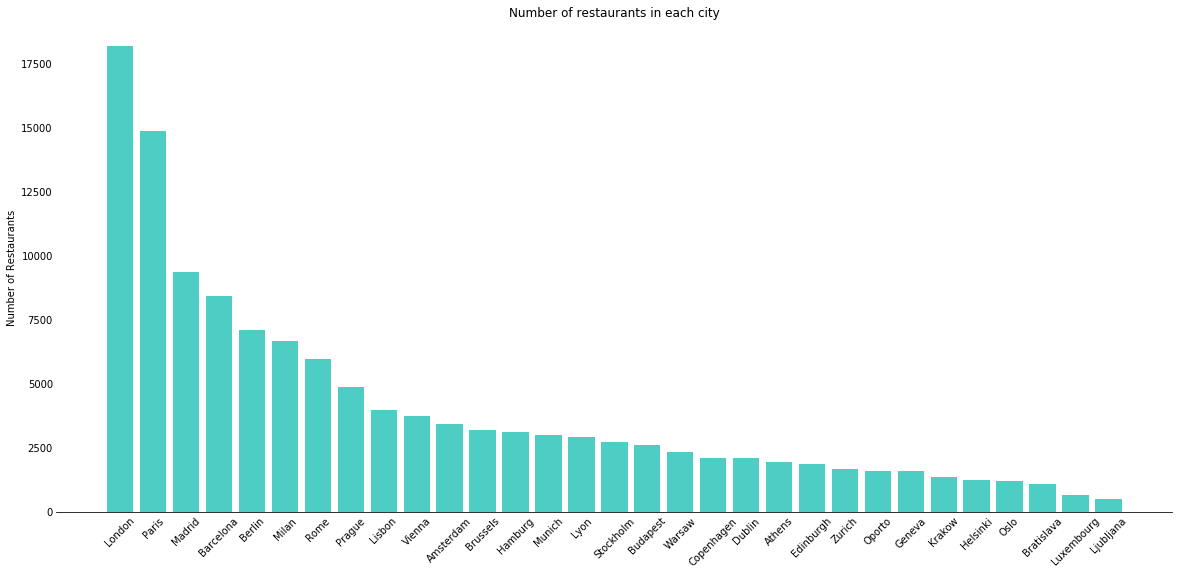

In [11]:
fig = plt.figure(figsize=(20, 9))
ax = plt.subplot();

df_restaurants_in_cities = ta_reviews.groupby('city').name.count().sort_values(ascending = False)

plt.bar(x = df_restaurants_in_cities.index, height=df_restaurants_in_cities, color="#4ECDC4");
plt.xticks(rotation='45');
plt.ylabel('Number of Restaurants');
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
ax.spines['left'].set_visible(False);
plt.title('Number of restaurants in each city');
ax.tick_params(direction='out', length=0, width=0, colors='black');

<a id="reviews_by_city"></a>

#### Where do the people talk more about the restaurants?



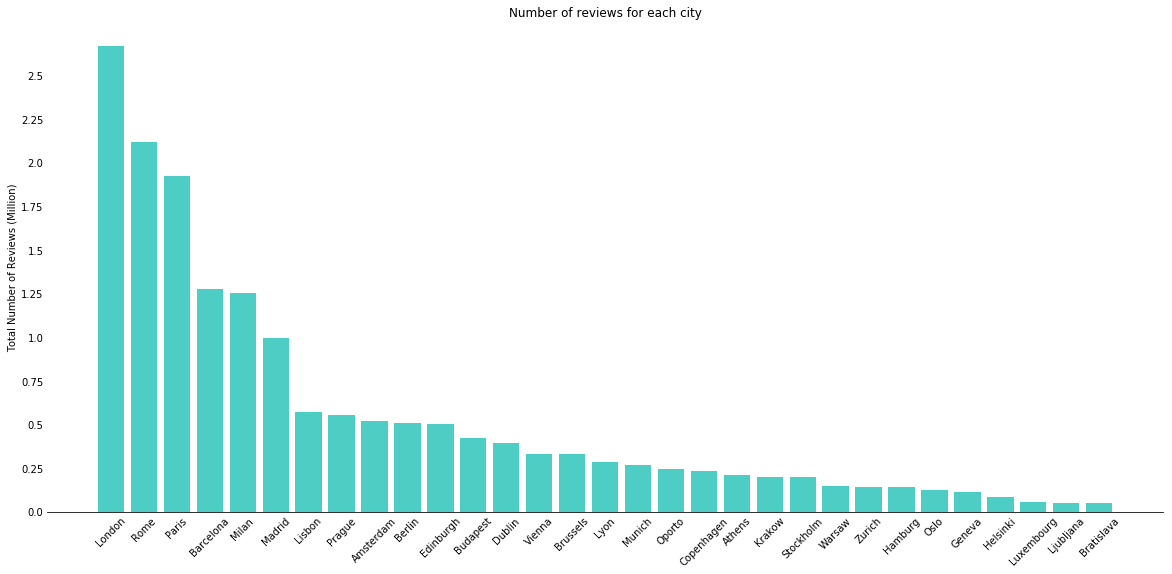

In [12]:
df_reviews_count = ta_reviews.groupby('city').reviews_number.sum().sort_values(ascending=False)
count_millions = np.arange(0, 2.14e6, 20e4)
count = np.arange(0, 2.6, 0.25)

fig = plt.figure(figsize=(20, 9))
ax = plt.subplot();

plt.bar(x = df_reviews_count.index, height=df_reviews_count, color="#4ECDC4");
plt.xticks(rotation='45');
plt.yticks(count_millions, count);
plt.ylabel('Total Number of Reviews (Million)');
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
ax.spines['left'].set_visible(False);
plt.title('Number of reviews for each city');
ax.tick_params(direction='out', length=0, width=0, colors='black');

As expected, London has the highest number of reviews, but the list appears rather different from the previous one, with Rome in second position having just the 5th highest number of restaurants.

Let's check the average number of reviews per city:

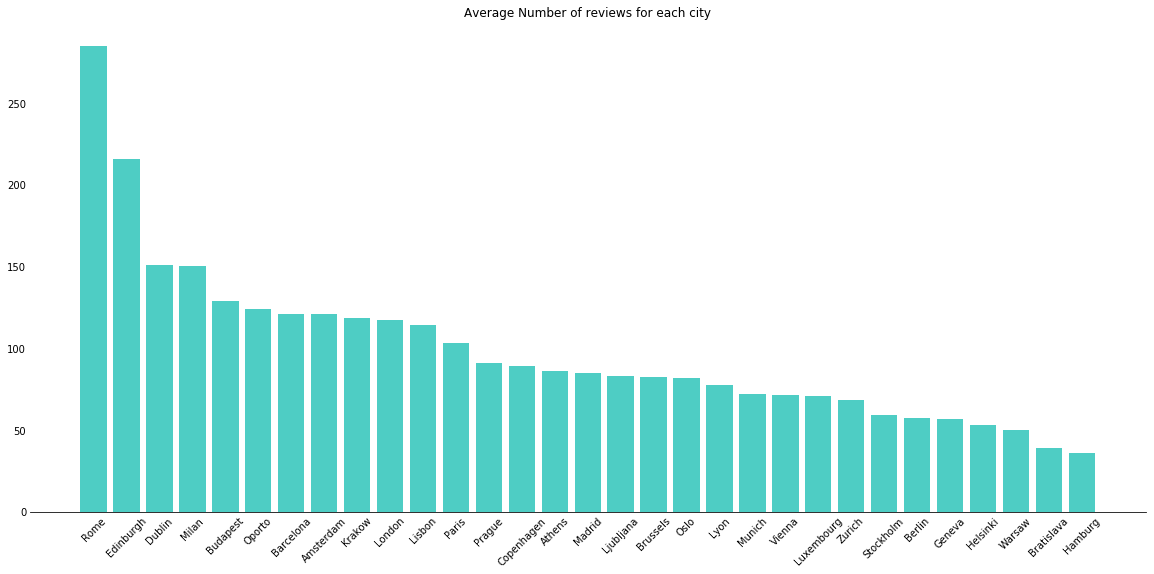

In [13]:
tot_reviews_city = pd.DataFrame(ta_reviews.groupby('city').reviews_number.sum())
tot_places_city = pd.DataFrame(ta_reviews.groupby('city').name.count())

reviews_per_city = pd.merge(tot_reviews_city, tot_places_city, how='outer', on='city')
reviews_per_city.rename(columns={'name':'number_of_places'}, inplace=True)
reviews_per_city['avg_reviews'] = round(reviews_per_city.reviews_number / reviews_per_city.number_of_places, 2)
reviews_per_city.sort_values(by='avg_reviews', ascending=False, inplace=True)

fig = plt.figure(figsize=(20, 9))
ax = plt.subplot();

plt.bar(x = reviews_per_city.index, height=reviews_per_city.avg_reviews, color="#4ECDC4");
plt.xticks(rotation='45');
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
ax.spines['left'].set_visible(False);
plt.title('Average Number of reviews for each city');
ax.tick_params(direction='out', length=0, width=0, colors='black');

In this case, the list has dramatically changed, with Rome in the first position and Edinburgh as second (while having a rather low number of reviewed restaurants).
Apparently these are the two cities which give people the most to talk about! 

<a id="rates_by_city"></a>
#### Did we eat well? In other words... let's rate this restaurant

But is what TripAdvisor's visitors say about restaurants Positive or Negative? Are the restaurants rated above or below the sufficiency? (we can consider a 3 as a neutral opinion)

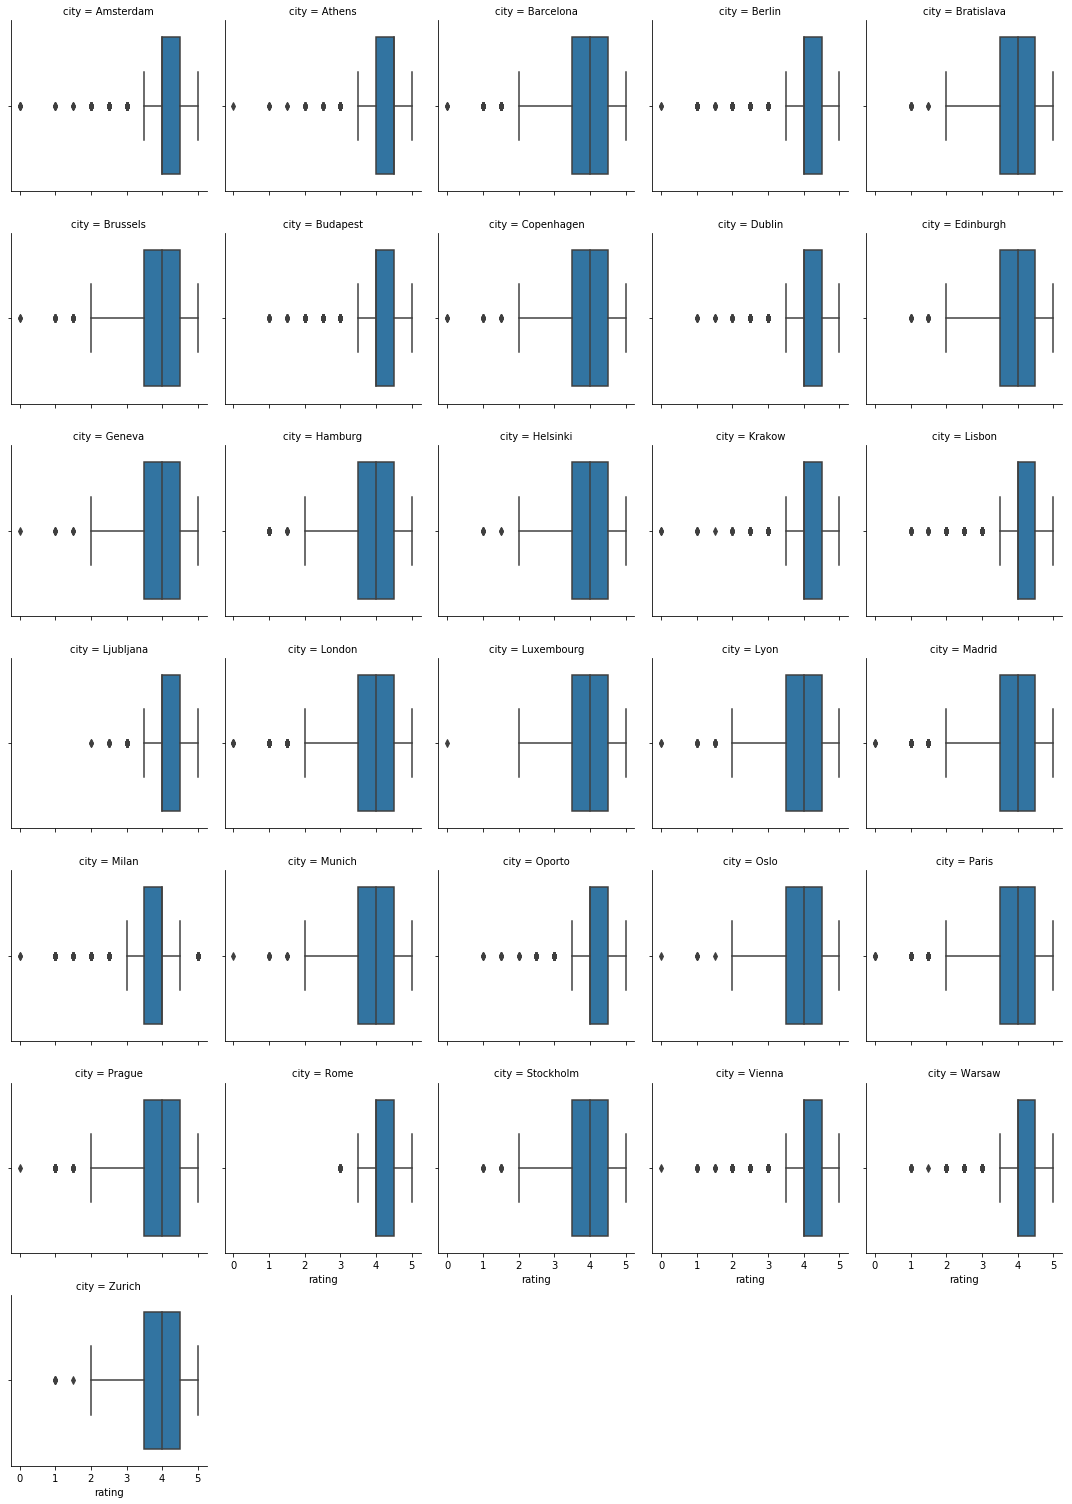

In [14]:
g = sb.FacetGrid(ta_reviews, col="city", col_wrap=5);
g.map(sb.boxplot, "rating", order = [1, 2, 3, 4, 5]);
ax.set_xticklabels([0, 1, 2, 3, 4, 5]);

In general, the ratings in every city tend to be mostly higher than 3. This might suggest that customers are usually tempted to leave a review when things are good (but this could be investigated further).

<a id="price_by_city"></a>

#### How much do we want to pay?

We found out that the customers were in general satisfied with the overall quality of the restaurants they chose. Was the price a parameter they used to leave negative or positive reviews about?

In [15]:
# first, let's replace the notation used in the dataset for the three price ranges ($, $$ - $$$, $$$$) with 
# something more intuitive (cheaper - medium - higher ranges) and replace the NaN ones (set as not available)

ta_reviews['price_range'] = ta_reviews['price_range'].fillna('NA')
price_ranges = {'$': 'Cheaper', '$$ - $$$': 'Medium', '$$$$': 'Higher', 'NA': 'NotAvailable'}
ta_reviews['price_range'] = ta_reviews.price_range.map(price_ranges)

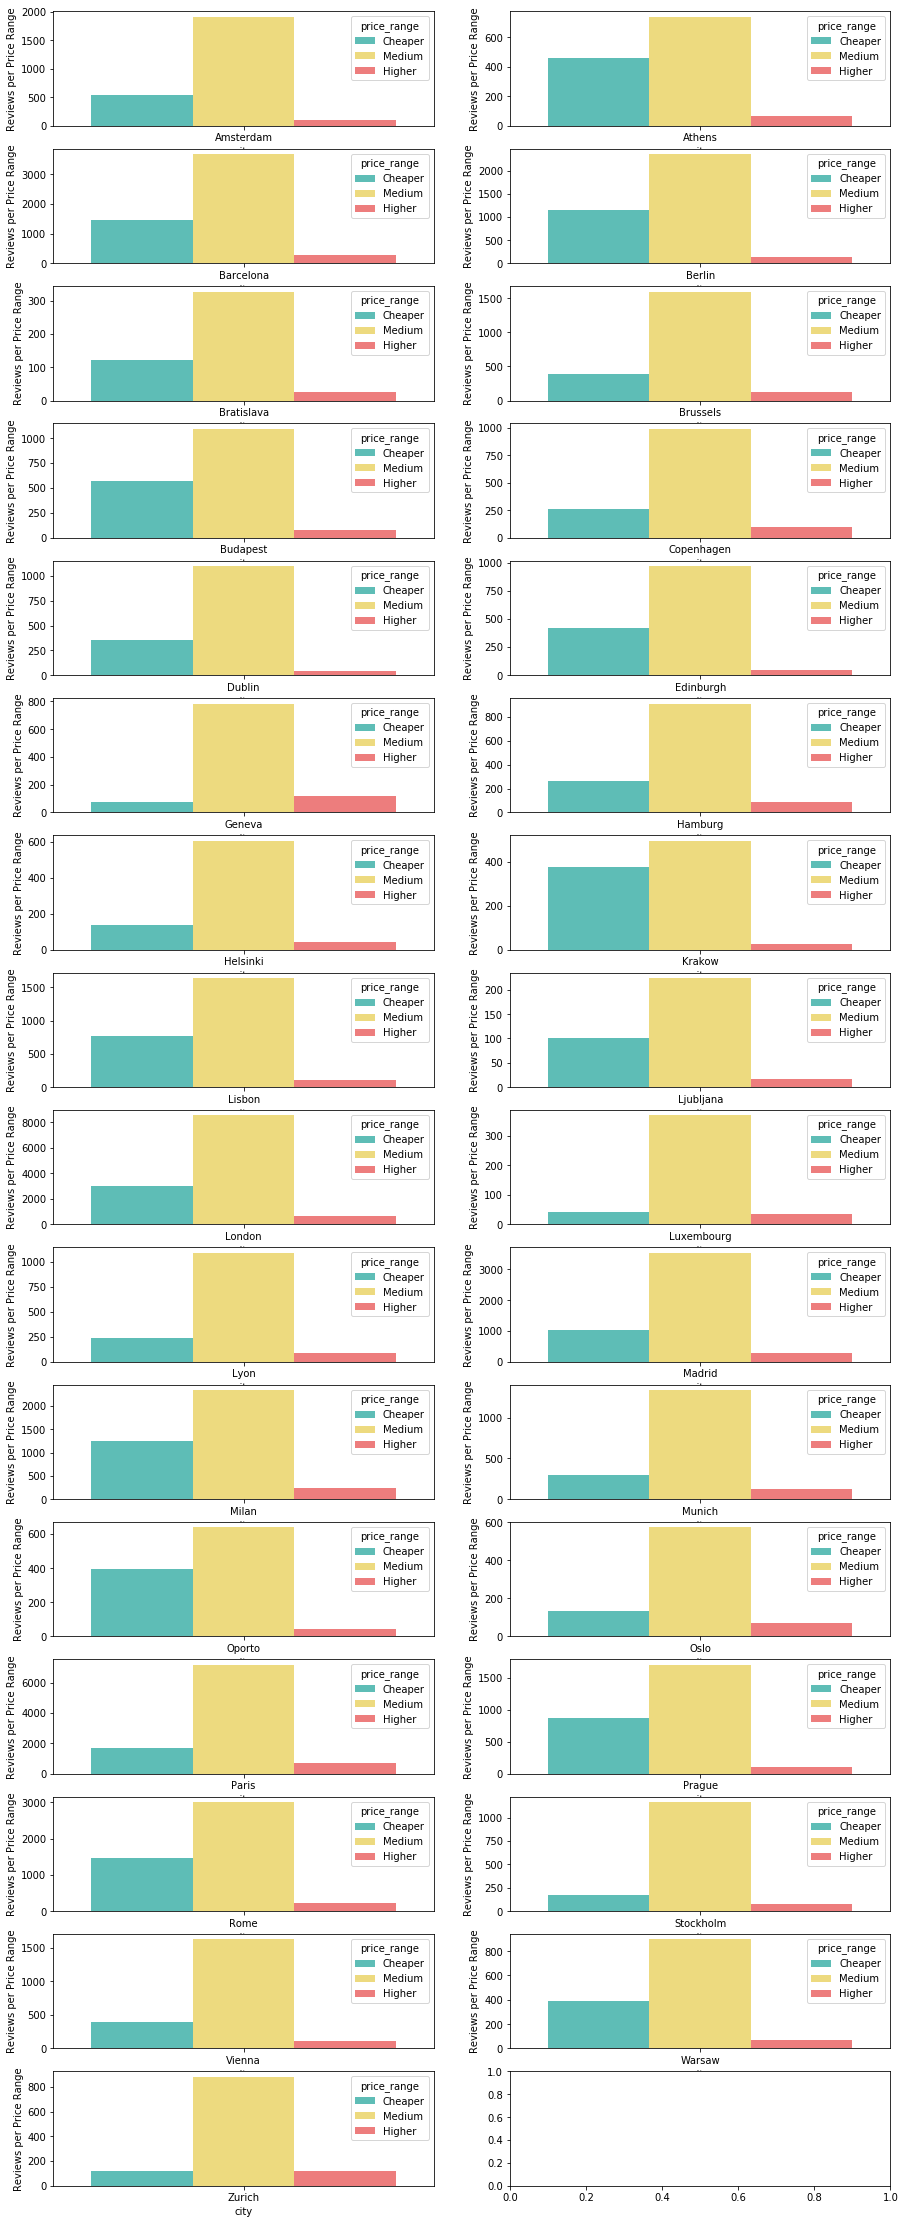

In [16]:
# filtering out the Not Available price range. In this situation, it doesn't provide much interesting info
ta_valid_reviews = ta_reviews[ta_reviews.price_range != 'NotAvailable']
cities = ta_valid_reviews.city.unique()

fig_price_ranges, ax_price_ranges = plt.subplots(16,2,figsize=(15,40))

ind = 1
for i in range(1,17):
    for j in range(1,3):
        if (ind <= 31):
            city = cities[ind-1]
            ind += 1
            city_revs = ta_valid_reviews[ta_valid_reviews.city == city]
            df_revs = pd.DataFrame(city_revs.groupby(['city', 'price_range']).name.count())
            df_revs = df_revs.reset_index()
            fig_price_ranges.add_subplot(ax_price_ranges[i-1, j-1])
            sb.barplot(data=df_revs, x = 'city', y = 'name', hue='price_range', hue_order = ['Cheaper', 'Medium', 'Higher'], palette = ['#4ECDC4', '#FFE66D', '#FF6B6B']);
            plt.ylabel('Reviews per Price Range');


In general, the restaurants are reviewed as Medium-priced (even in cities like London or the italian Rome and Milan, where food is almost a religion). This is probably due to travellers trying to save and settling for more _normal_ menus (nothing too fancy... they have plenty of other places to see in the city!).<br>
The only exception are the two cities in Switzerland (Geneva and Zurich) where the _Higher_ ranged restaurants are at least as many (or more than, like in Geneva) as the Cheaper ones. Do people go to Switzerland looking for expensive places to eat or is it just the cost of life higher in Switzerland?

<a id="reviews_by_price"></a>

#### Talking about the price

Taking into account that most of the restaurants have been rated as Medium-priced, how are reviews distributed according to the price range?

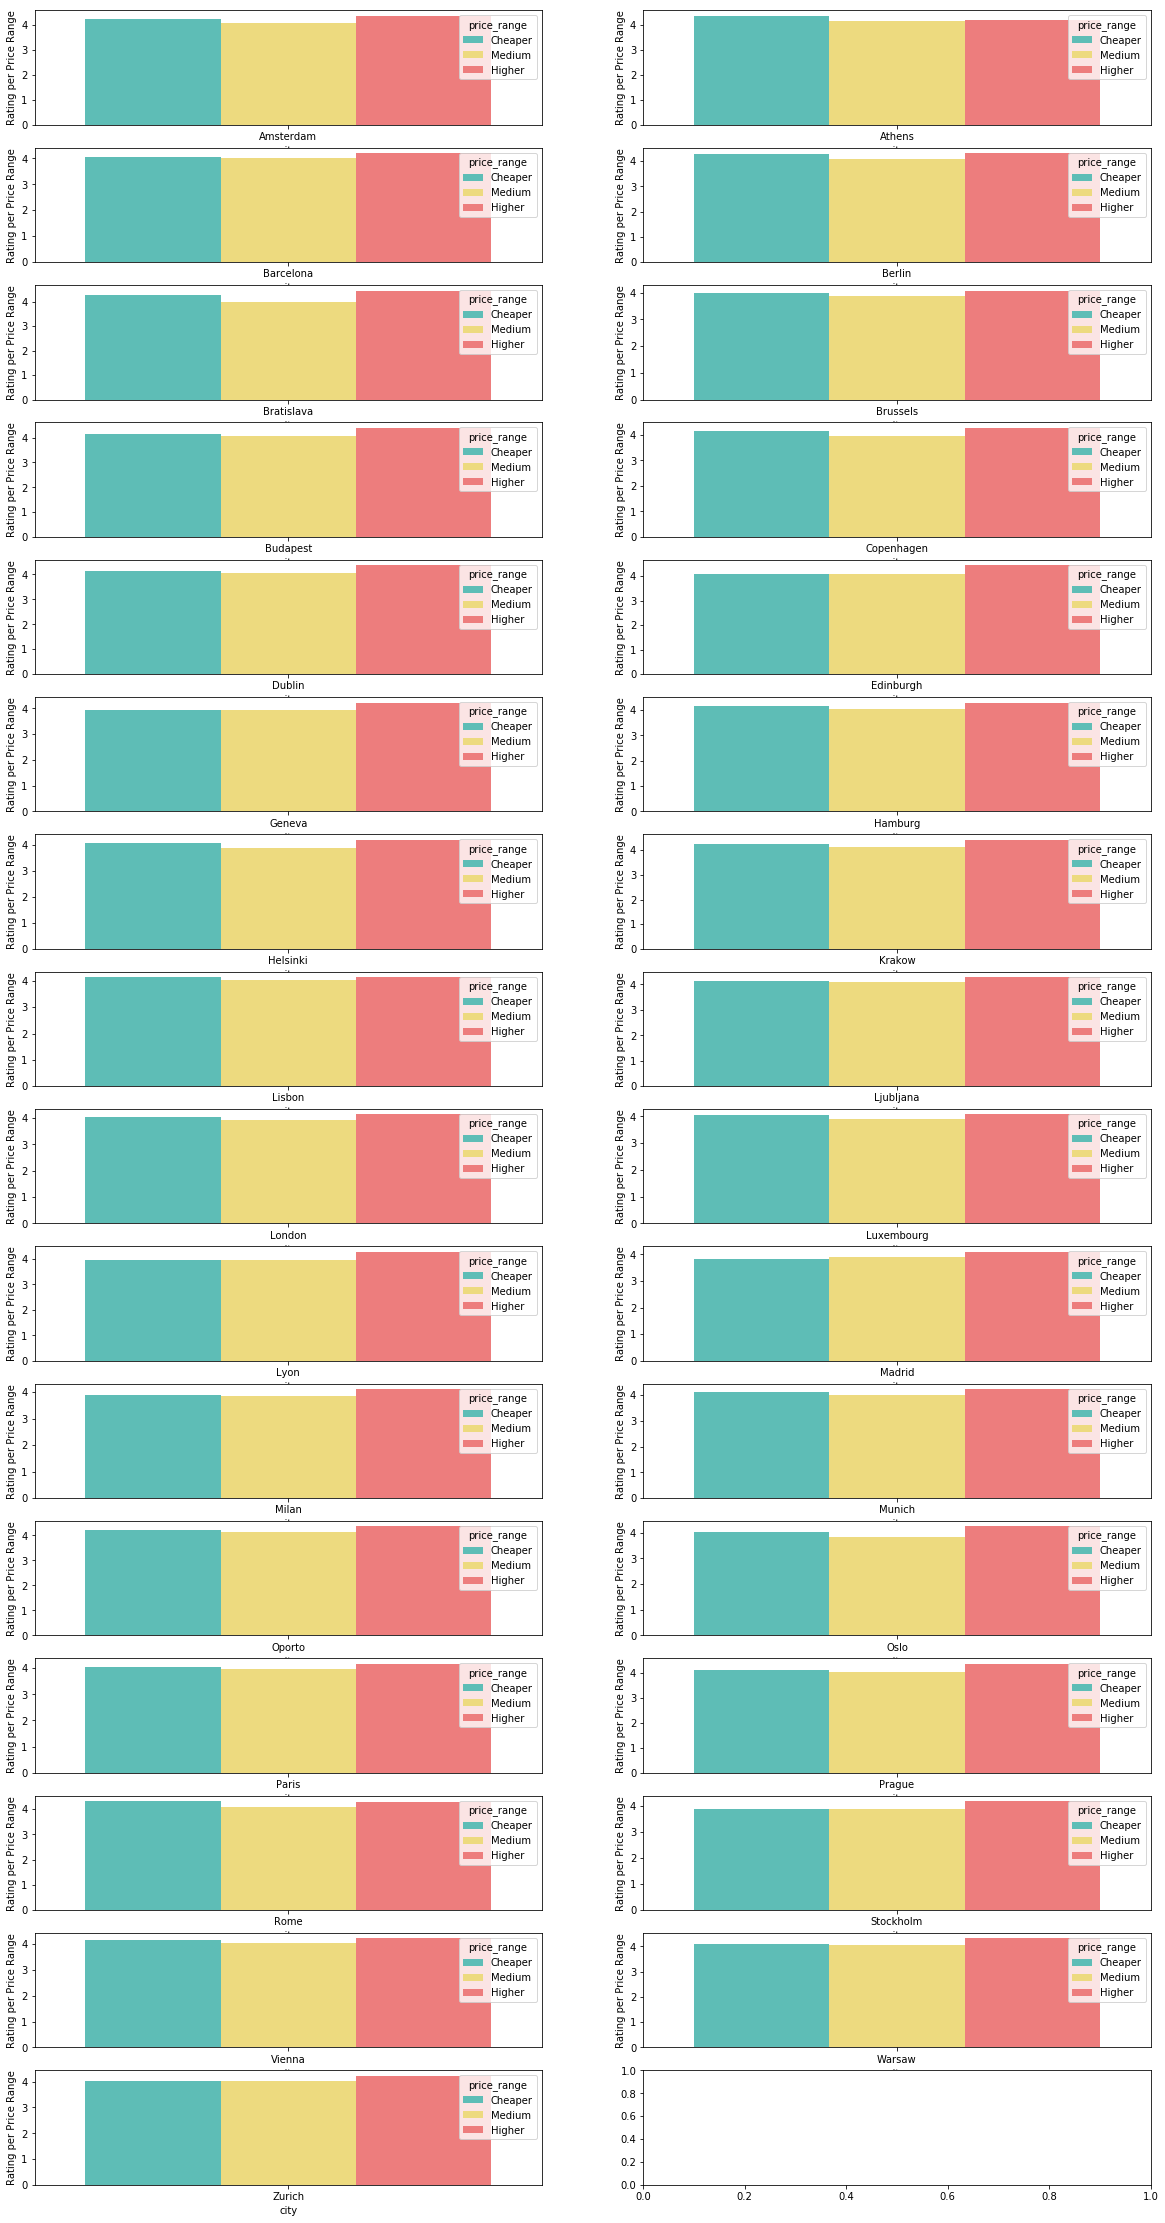

In [17]:
fig_price_ranges, ax_price_ranges = plt.subplots(16,2,figsize=(20,40))

ind = 1
for i in range(1,17):
    for j in range(1,3):
        if (ind <= 31):
            city = cities[ind-1]
            ind += 1
            city_revs = ta_valid_reviews[ta_valid_reviews.city == city]
            df_revs = pd.DataFrame(city_revs.groupby(['city', 'price_range']).rating.mean())
            df_revs = df_revs.reset_index()
            fig_price_ranges.add_subplot(ax_price_ranges[i-1, j-1])
            sb.barplot(data=df_revs, x = 'city', y = 'rating', hue='price_range', hue_order = ['Cheaper', 'Medium', 'Higher'], palette = ['#4ECDC4', '#FFE66D', '#FF6B6B']);
            plt.ylabel('Rating per Price Range');

Breaking down the ratings by price range doesn't show much difference among the ratings given. On average the customers seem quite satisfied of the places they've visited: no price range in any of the cities appears to be struggling compared to the others (and the _High-priced_ restaurants in Switzerland seem to be worth the price, since they are rated as the best ones!)

Let's take a look into the average number of reviews per price range: does the price range somehow influence the possibility of a customer to leave a review?

In [18]:
# summing the reviews by city and price range
reviews_city_price = pd.DataFrame(ta_valid_reviews.groupby(['city', 'price_range']).reviews_number.sum())
# retrieving the number of restaurants by city and price
places_city_price = pd.DataFrame(ta_valid_reviews.groupby(['city', 'price_range']).name.count())

# let's add the corresponding city
reviews_city_price['restaurants_number'] = places_city_price['name']

# let's calculate the average number of reviews for each price range
reviews_city_price['avg_reviews'] = round(reviews_city_price.reviews_number / reviews_city_price.restaurants_number, 1)

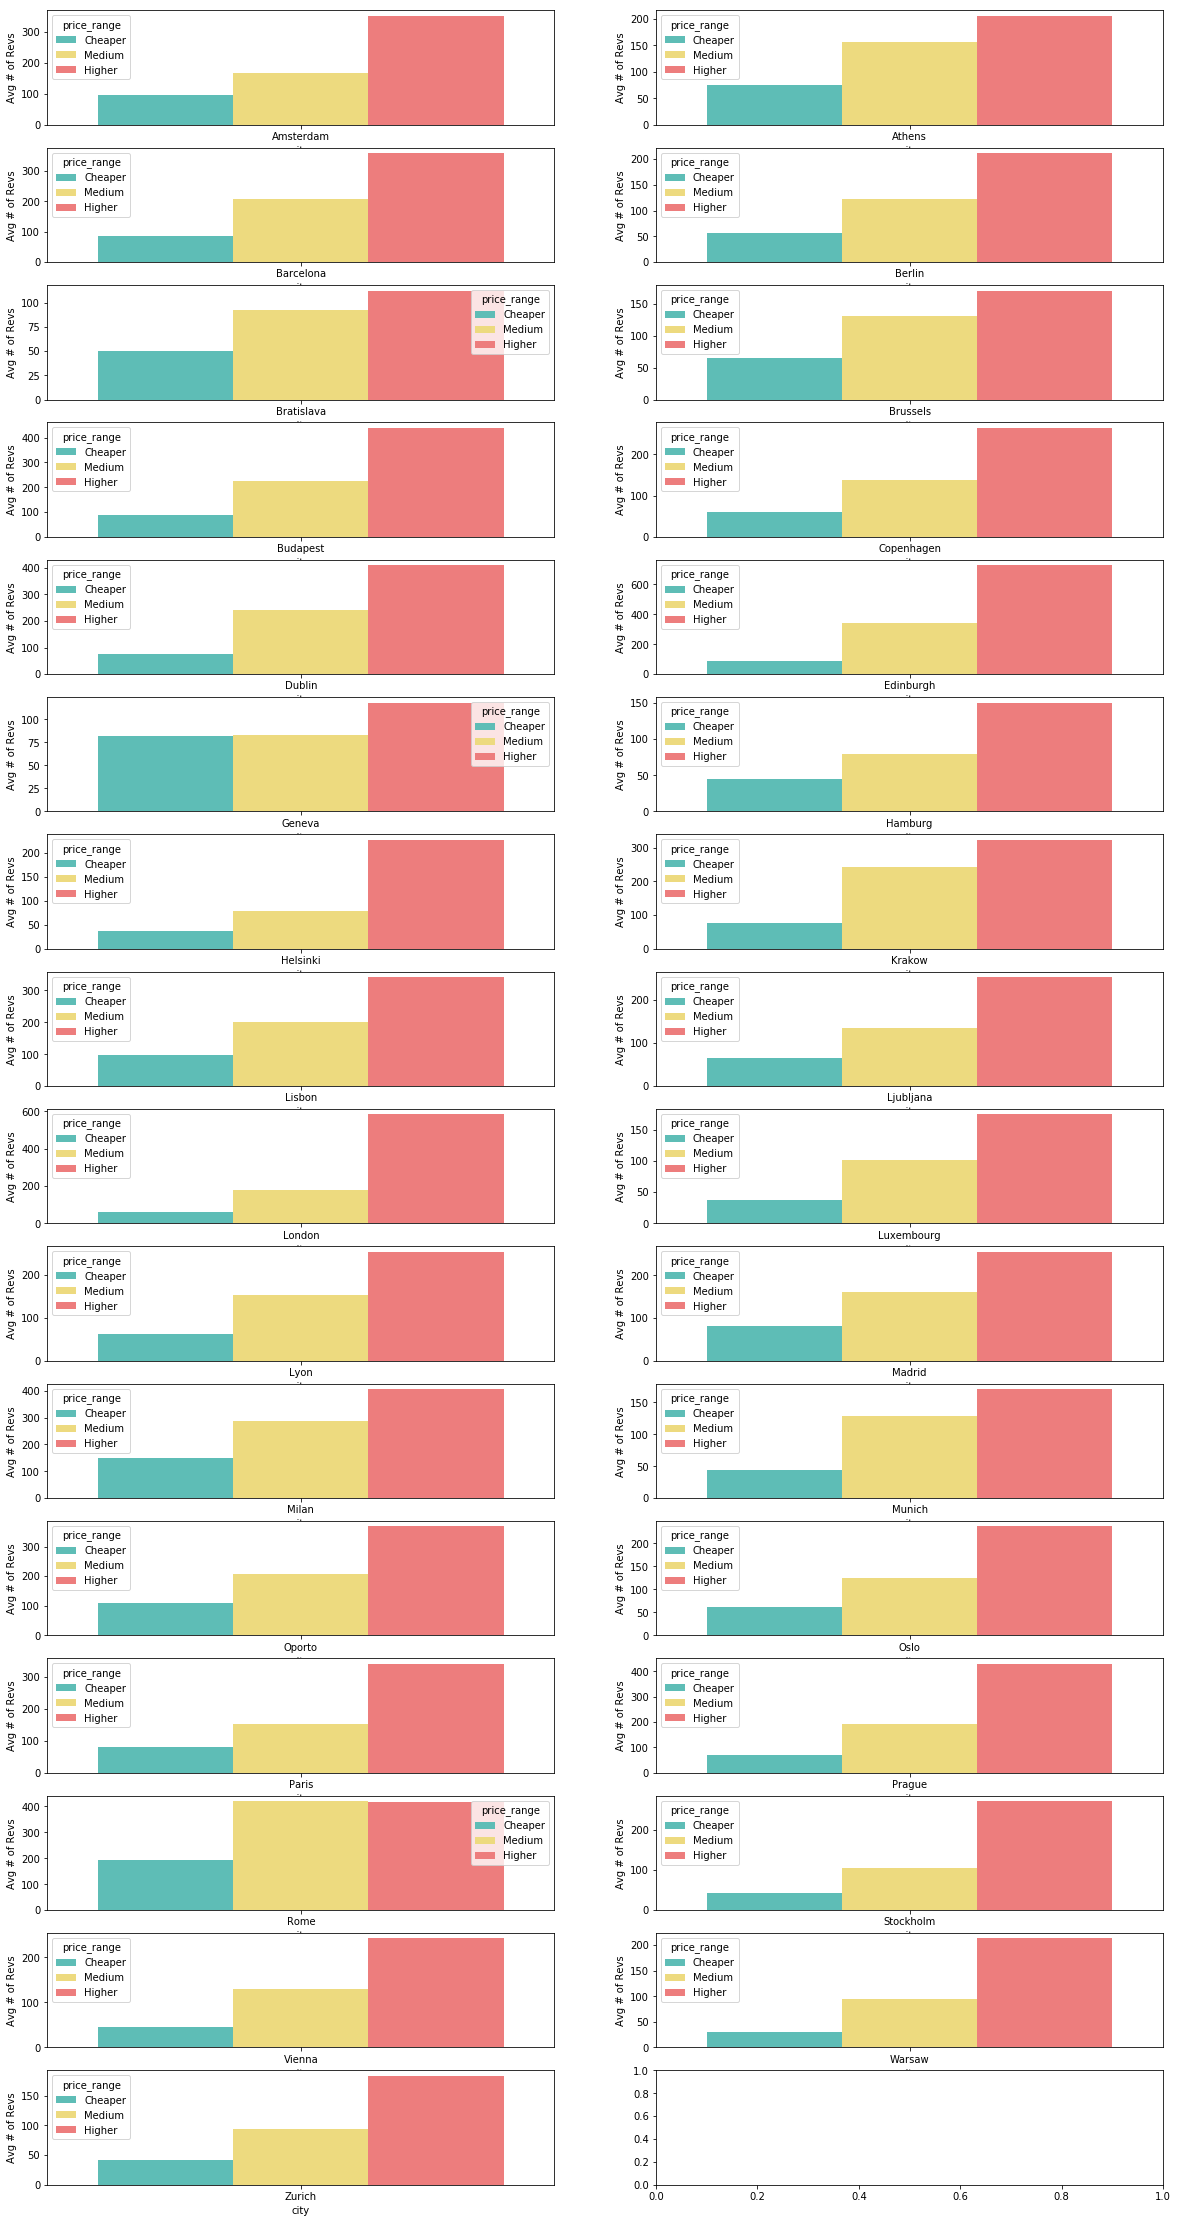

In [19]:
fig_price_ranges, ax_price_ranges = plt.subplots(16,2,figsize=(20,40))

ind = 1
for i in range(1,17):
    for j in range(1,3):
        if (ind <= 31):
            city = cities[ind-1]
            ind += 1
            city_revs = pd.DataFrame(reviews_city_price.loc[(city), 'avg_reviews'])
            city_revs['city'] = city
            city_revs = city_revs.reset_index()
            fig_price_ranges.add_subplot(ax_price_ranges[i-1, j-1])
            sb.barplot(data=city_revs, x = 'city', y = 'avg_reviews', hue='price_range', hue_order = ['Cheaper', 'Medium', 'Higher'], palette = ['#4ECDC4', '#FFE66D', '#FF6B6B']);            
            plt.ylabel('Avg # of Revs');

In all the cities the most discussed restaurants belong to the higher priced range: the higher the expected quality and the higher the attention paid by the customers.

<a id="rates_by_cuisine"></a>

### It's a matter of style

The dataset avails of the column _cuisine-style_ which stores the cuisine available in each of the reviewed places. This is an interesting starting point to understand how cuisines impact TripAdvisor's visitors.

First of all, we have to manage the list of cuisine styles in a way that we can use the data and produce some statistics. Since there's just one rating for each place, all the cuisine styles are stored in a single column: we assume that the rating given to each place is good for all the styles they propose.<br>
The goal is to create a single row for each of the cuisine_styles available for each place.

In [20]:
# I create a new dataframe with just the columns that I consider more interesting
cuisines = ta_reviews.loc[:, ['city', 'name', 'cuisine_style', 'rating', 'reviews_number']]

# first of all, let's clean the content of cuisine_style by removing the square brakets
cuisines.cuisine_style = cuisines.cuisine_style.str.replace('[', '')
cuisines.cuisine_style = cuisines.cuisine_style.str.replace(']', '')

# renaming the columns
cuisines.columns = ['city', 'place', 'cuisine_style', 'rating', 'reviews_number']
cuisines.head(10)

,city,place,cuisine_style,rating,reviews_number
0,Amsterdam,Martine of Martine's Table,"'French', 'Dutch', 'European'",5.0,136
1,Amsterdam,De Silveren Spiegel,"'Dutch', 'European', 'Vegetarian Friendly', 'G...",4.5,812
2,Amsterdam,La Rive,"'Mediterranean', 'French', 'International', 'E...",4.5,567
3,Amsterdam,Vinkeles,"'French', 'European', 'International', 'Contem...",5.0,564
4,Amsterdam,Librije's Zusje Amsterdam,"'Dutch', 'European', 'International', 'Vegetar...",4.5,316
5,Amsterdam,Ciel Bleu Restaurant,"'Contemporary', 'International', 'Vegetarian F...",4.5,745
6,Amsterdam,Zaza's,"'French', 'International', 'Mediterranean', 'E...",4.5,1455
7,Amsterdam,Blue Pepper Restaurant And Candlelight Cruises,"'Asian', 'Indonesian', 'Vegetarian Friendly', ...",4.5,675
8,Amsterdam,Teppanyaki Restaurant Sazanka,"'Japanese', 'Asian', 'Vegetarian Friendly', 'V...",4.5,923
9,Amsterdam,Rob Wigboldus Vishandel,"'Dutch', 'Seafood', 'Fast Food'",4.5,450


In [21]:
# now i create a row for each cuisine_type available for each restaurant. I'll keep the rating and reviews_number
# the same for each cuisine_style for each restaurant

# removing restaurants with no cuisine_style available
all_cuisines = cuisines[cuisines.cuisine_style.isna() == False]

dic = []

for i in all_cuisines.iterrows():
    # splitting the cuisine_style by commas so that i can create a brand new row of data for just that cuisine
    for j in range(0, len(i[1].cuisine_style.split(', '))):
        dic.append({
            'city': i[1].city,
            'place': i[1].place,
            'cuisine_style': i[1].cuisine_style.split(', ')[j].replace('\'', ''),
            'rating': i[1].rating,
            'reviews_number': i[1].reviews_number
        })
    
cuisines_list = pd.DataFrame(data=dic)

In [22]:
cuisines_list.head(15)

,city,place,cuisine_style,rating,reviews_number
0,Amsterdam,Martine of Martine's Table,French,5.0,136
1,Amsterdam,Martine of Martine's Table,Dutch,5.0,136
2,Amsterdam,Martine of Martine's Table,European,5.0,136
3,Amsterdam,De Silveren Spiegel,Dutch,4.5,812
4,Amsterdam,De Silveren Spiegel,European,4.5,812
5,Amsterdam,De Silveren Spiegel,Vegetarian Friendly,4.5,812
6,Amsterdam,De Silveren Spiegel,Gluten Free Options,4.5,812
7,Amsterdam,La Rive,Mediterranean,4.5,567
8,Amsterdam,La Rive,French,4.5,567
9,Amsterdam,La Rive,International,4.5,567


<a id="cuisine_types"></a>

#### Cuisine Diversity

We can quickly check how many single cuisine styles have been reviewed:

In [23]:
cuisines_list.cuisine_style.nunique()

127

And see a top 10 of the most common cuisine styles

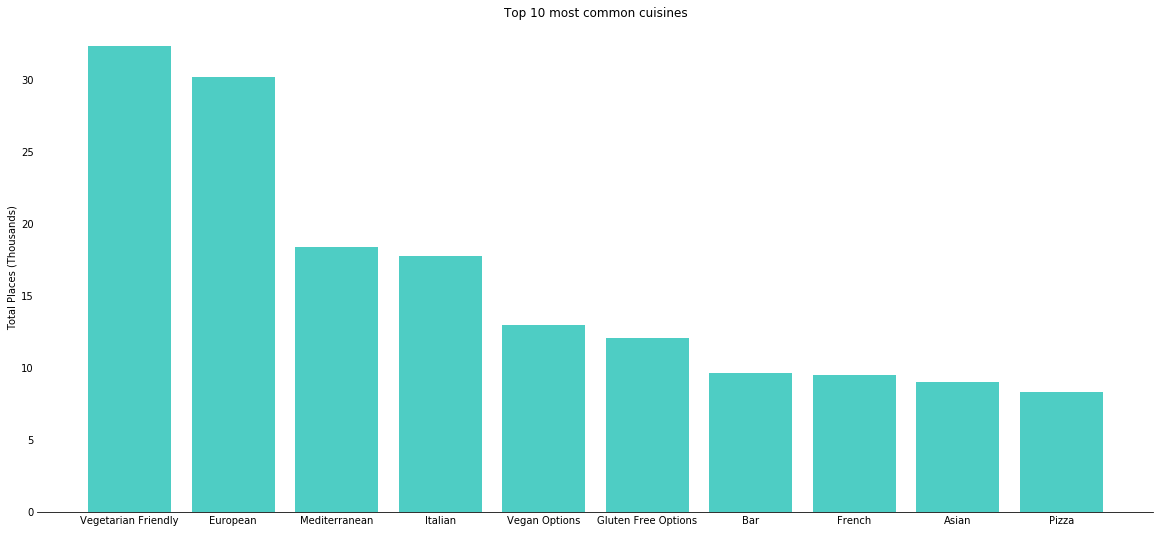

In [24]:
df_cuisine_style = cuisines_list.cuisine_style.value_counts().sort_values(ascending = False)[:10]


count_ths = np.arange(0, 3.3e4, 5e3)
count = np.arange(0, 35, 5)

fig = plt.figure(figsize=(20, 9))
ax = plt.subplot();

plt.bar(x = df_cuisine_style.index, height=df_cuisine_style, color="#4ECDC4");

plt.yticks(count_ths, count);
plt.ylabel('Total Places (Thousands)');
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
ax.spines['left'].set_visible(False);
plt.title('Top 10 most common cuisines');
ax.tick_params(direction='out', length=0, width=0, colors='black');

Vegetarian Friendly places are clearly the most reviewed ones, followed by mostly European-style cuisine.

What about the most reviewed ones?

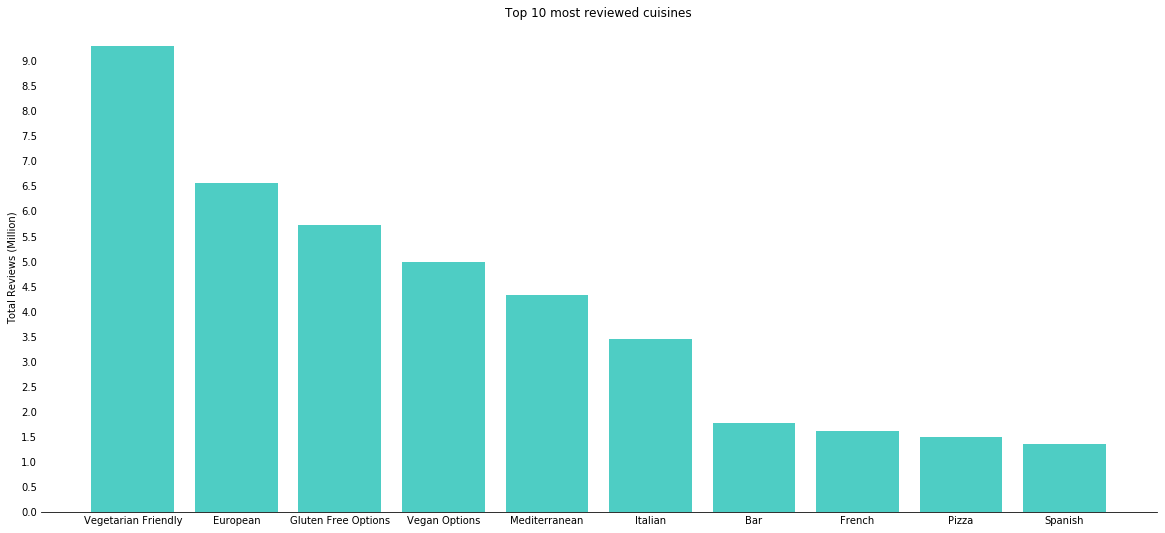

In [25]:
df_cuisine_style = cuisines_list.groupby('cuisine_style').reviews_number.sum().sort_values(ascending=False)[:10]

count_ths = np.arange(0, 9.3e6, 5e5)
count = np.arange(0, 9.3, 0.5)

fig = plt.figure(figsize=(20, 9))
ax = plt.subplot();

plt.bar(x = df_cuisine_style.index, height=df_cuisine_style, color="#4ECDC4");

plt.yticks(count_ths, count);
plt.ylabel('Total Reviews (Million)');
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
ax.spines['left'].set_visible(False);
plt.title('Top 10 most reviewed cuisines');
ax.tick_params(direction='out', length=0, width=0, colors='black');

Not a huge difference, but it's notable that the Vegan and Gluten Free Options are very likely to be reviewed by the customers.

Due to the high number of unique cuisine styles, let's focus only on the 10 most reviewed ones.

In [26]:
# recovering the index of the 10 most reviewed cuisine styles
top_cuisines_index = cuisines_list.groupby('cuisine_style').reviews_number.sum().sort_values(ascending=False)[:10].index

# filtering data
top_cuisines= pd.DataFrame(cuisines_list[cuisines_list.cuisine_style.isin(top_cuisines_index)])

In [27]:
top_cuisines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159513 entries, 0 to 286310
Data columns (total 5 columns):
city              159513 non-null object
place             159513 non-null object
cuisine_style     159513 non-null object
rating            156042 non-null float64
reviews_number    159513 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 7.3+ MB


Some ratings are missing, I'll try to replace the null values with the average rating for that city and cuisine style

In [28]:
# not all cities have NaN ratings, I'll make a list of only the ones who do
no_rating_cities = top_cuisines[top_cuisines.rating.isna()].city.unique()

# and then I calculate the average rating by City + Cuisine_Style and I'll assign that value 
# to the NaN rating cols

for i in range(0,10):
    style = top_cuisines_index[i]
    for c in range(0, len(no_rating_cities)):
        city = no_rating_cities[c]
        # mean rating
        mean_rating = round(top_cuisines[(top_cuisines.cuisine_style == style) & (top_cuisines.city == city)].rating.mean(), 1)
        # raplacing NaN with the mean_rating
        top_cuisines.loc[(top_cuisines.cuisine_style == style) & (top_cuisines.city == city) & (top_cuisines.rating.isna() == True), 'rating'] = mean_rating


<a id="best_styles"></a>
### Simply the best

Among the top 10 cuisines, what's the best rated one?

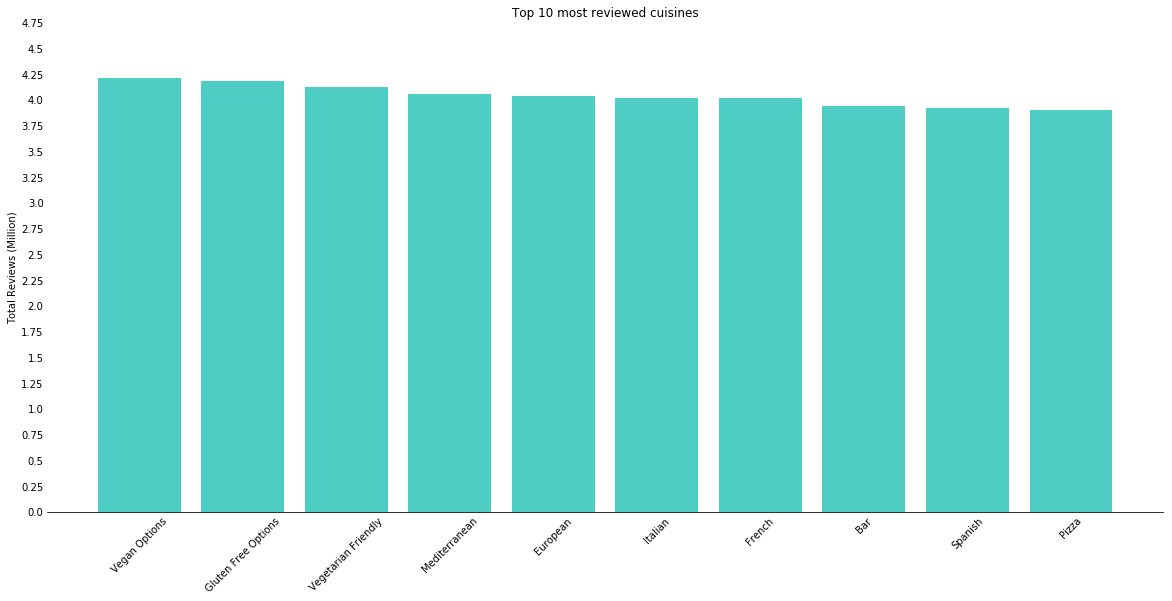

In [29]:
df_top_average = top_cuisines.groupby('cuisine_style').rating.mean().sort_values(ascending=False)

ranking = np.arange(0, 5, 0.25)
count = np.arange(0, 5, 0.25)
labels = [round(item, 2) for item in count]

fig = plt.figure(figsize=(20, 9))
ax = plt.subplot();

plt.bar(x = df_top_average.index, height=df_top_average, color="#4ECDC4");
plt.xticks(rotation='45');
plt.yticks(ranking, labels);
plt.ylabel('Total Reviews (Million)');
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
ax.spines['left'].set_visible(False);
plt.title('Top 10 most reviewed cuisines');
ax.tick_params(direction='out', length=0, width=0, colors='black');

Vegan and Gluten Free Options are again on the top of the preferences of the reviewers, although the difference among the various cuisines is not very big (between Vegan Options and Pizza there's a 0.3 pts difference)


<a id="where_to_eat_what"></a>

### Where to eat... what?

So, we have the whole Europe to choose places to eat from. What's the top 3 cuisine styles by number of reviews and ratings in all the cities?<br> In this way, in our next trip, we'll already know what's the best cuisine style in the city we'll visit... better be prepared!

In [30]:
df_top_options = cuisines_list.groupby(['city', 'cuisine_style']).agg({"rating": "mean", "reviews_number": "sum"}).sort_values(by=['city', 'cuisine_style', "reviews_number", "rating"], ascending=False)
top_options = df_top_options.groupby('city').head(50).sort_values(by=['city', "reviews_number", "rating"], ascending=[True, False, False]).round(2)

In [31]:
map_cities = {'Amsterdam': {
        'lat': 52.3547,
        'lon': 4.7638,
        'flag': 'https://i.imgur.com/blc3acB.png'
    },
    'Athens': {
        'lat': 37.9908,
        'lon': 23.7033,
        'flag': 'https://i.imgur.com/EGGLpd1.png'
    },
    'Barcelona': {
        'lat': 41.3948,
        'lon': 2.0787,
        'flag': 'https://i.imgur.com/vUh0XT5.png'
    }, 
    "Berlin": {
        'lat': 52.5069, 
        'lon': 13.3345,
        'flag': 'https://i.imgur.com/IWmwjUA.png'
    },
    "Bratislava": {
        'lat': 48.1359, 
        'lon': 16.9758,
        'flag': 'https://i.imgur.com/48ARppO.png'
    },              
    "Brussels": {
        'lat': 50.8550, 
        'lon': 4.3053,
        'flag': 'https://i.imgur.com/8dsgG0Z.png'
    },              
    "Budapest": {
        'lat': 47.4813, 
        'lon': 18.9902,
        'flag': 'https://i.imgur.com/3wn3zdO.png'
    },              
    "Copenhagen": {
        'lat': 55.6713, 
        'lon': 12.4537,
        'flag': 'https://i.imgur.com/6qIQO7a.png'
    },                
    "Dublin": {
        'lat': 53.3244, 
        'lon': -6.3857,
        'flag': 'https://i.imgur.com/XKBE096.png'
    },
    "Edinburgh": {
        'lat': 55.941, 
        'lon': -3.2753,
        'flag': 'https://i.imgur.com/D0M33Pp.png'
    },
    "Geneva": {
        'lat': 46.2050, 
        'lon': 6.1090,
        'flag': 'https://i.imgur.com/bYvB2U5.png'
    },
    "Hamburg": {
        'lat': 53.5586, 
        'lon': 9.6476,
        'flag': 'https://i.imgur.com/RMgJjUZ.png'
    },
    "Helsinki": {
        'lat': 60.1100, 
        'lon': 24.7385,
        'flag': 'finland'
    },
    "Krakow": {
        'lat': 50.0469, 
        'lon': 19.8647,
        'flag': 'https://i.imgur.com/Pz2wDfL.png'
    },
    "Lisbon": {
        'lat': 38.7437, 
        'lon': -9.2302,
        'flag': 'https://i.imgur.com/u0PAGku.png'
    },
    "Ljubljana": {
        'lat': 46.06627, 
        'lon': 14.3920,
        'flag': 'https://i.imgur.com/SaeK70A.png'
    },
    "London": {
        'lat': 51.5287, 
        'lon': -0.3817,
        'flag': 'https://i.imgur.com/82dLnLB.png'
    },
    "Luxembourg": {
        'lat': 49.8148, 
        'lon': 5.5728,
        'flag': 'https://i.imgur.com/jKBqD0Z.png'
    },
    "Lyon": {
        'lat': 45.7580, 
        'lon': 4.7650,
        'flag': 'https://i.imgur.com/7vrY3jL.png'
    },
    "Madrid": {
        'lat': 40.4381, 
        'lon': -3.8196,
        'flag': 'https://i.imgur.com/vUh0XT5.png'
    },
    "Milan": {
        'lat': 45.4628, 
        'lon': 9.1076,
        'flag': 'https://i.imgur.com/9ciRLpM.png'
    },
    "Munich": {
        'lat': 48.1550, 
        'lon': 11.4017,
        'flag': 'https://i.imgur.com/IWmwjUA.png'
    },
    "Oporto": {
        'lat': 41.1622, 
        'lon': -8.6919,
        'flag': 'https://i.imgur.com/u0PAGku.png'
    },
    "Oslo": {
        'lat': 59.8939, 
        'lon': 10.6450,
        'flag': 'https://i.imgur.com/FM8gW1N.png'
    },
    "Paris": {
        'lat': 48.8589, 
        'lon': 2.2770,
        'flag': 'https://i.imgur.com/7vrY3jL.png'
    },
    "Prague": {
        'lat': 50.0598, 
        'lon': 14.3255,
        'flag': 'https://i.imgur.com/1gDnRgD.png'
    },
    'Rome': {
        'lat': 41.9102,
        'lon': 12.3959,
        'flag': 'https://i.imgur.com/9ciRLpM.png'
    },
    "Stockholm": {
        'lat': 59.3262, 
        'lon': 17.8419,
        'flag': 'https://i.imgur.com/VSHZpY9.png'
    },
    "Vienna": {
        'lat': 48.2208, 
        'lon': 16.2399,
        'flag': 'https://i.imgur.com/xRyqWqH.png'
    },
     "Warsaw": {
        'lat': 52.2330, 
        'lon': 20.7810,
        'flag': 'https://i.imgur.com/Pz2wDfL.png'
    },
     "Zurich": {
        'lat': 47.3775, 
        'lon': 8.4666,
        'flag': 'https://i.imgur.com/bYvB2U5.png'
    }             
}

In [32]:
import folium
import base64
from folium import IFrame

def get_flag(city):
    flag = map_cities.get(city)
    flag_url = flag['flag']
    return(flag_url)

def get_top_options2(city):
    opt = top_options[top_options.index.get_level_values('city').isin([city])][:3]
    opt = opt.reset_index()
    opt = opt.sort_values(by=["rating", "reviews_number"], ascending=[False, False])
    top_3 = ""
    icon_class = ""
    for i in opt.iterrows():
        if (i[1]['cuisine_style'] == "Gluten Free Options") or (i[1]['cuisine_style'] == "Vegan Options"):
            icon_class = "fa-pagelines"
        elif i[1]['cuisine_style'] == "Vegetarian Friendly":
            icon_class = "fa-tree"
        else:
            icon_class = "fa-globe"
        top_3 += "<div  style =\"height:25px;\"><i class=\"fa "+ icon_class + "\"></i>&nbsp;" + i[1]['cuisine_style'] + "&nbsp;" + str(i[1]['rating']) + " (" + str(i[1]['reviews_number']) +  " reviews)</div>"
    return(top_3)

europe = folium.Map(
    location=[52.4214, 8.3750],
    tiles = "OpenStreetMap",
    zoom_start=4
)
    
for k, v in map_cities.items():
    flag = get_flag(k)
    html =  "<!DOCTYPE html><html><head><link rel=\"stylesheet\" href=\"https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css\"></head><body>"
    html += "<div><div style =\"height:30px;\"><strong>{}</strong>&nbsp;<img src='{}' width='18px' height='18px'></div><div>{}</div>".format(k, flag, get_top_options2(k))
    html += "</body></html>"    
    iframe = folium.IFrame(html, width=(300)+20, height=(110)+20)
    popup = folium.Popup(iframe, max_width=1000)    
    
    folium.Marker(location =[v['lat'], v['lon']], 
                popup=popup,
                icon = folium.Icon(color='darkpurple', icon='fa-cutlery', prefix='fa')
    ).add_to(europe)    

europe

[... continues ...]